# Machine Learning S7 Project - Predicting Futures Prices on Commodities

## I - Data Exploration

In this section, we will explore the dataset to understand it better.

In [51]:
# Load the packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# We make cool looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [52]:
# Read the file in a dataframe format
df = pd.read_csv("all_commodities_futures_collection.csv")
print(f"Data loaded successfully: {len(df)} records.")
df.head()

Data loaded successfully: 135295 records.


,ticker,commodity,category,date,open,high,low,close,volume
0,HE=F,Lean Hogs,Animal Products,2002-03-04,59.700001,59.875000,59.599998,59.650002,0
1,HE=F,Lean Hogs,Animal Products,2002-03-05,59.150002,59.150002,58.700001,58.799999,0
2,HE=F,Lean Hogs,Animal Products,2002-03-06,58.500000,58.799999,57.700001,57.700001,0
3,HE=F,Lean Hogs,Animal Products,2002-03-07,58.200001,58.599998,58.000000,58.400002,0
4,HE=F,Lean Hogs,Animal Products,2002-03-08,58.250000,58.250000,57.900002,58.049999,0


In [53]:
# Categorize the columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Print the structure
print(f"Dataset Shape: {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}.")
print(df.info())

Dataset Shape: 135295 rows and 9 columns.
Date Range: 2000-01-03 to 2024-06-24.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135295 entries, 0 to 135294
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ticker     135295 non-null  object 
 1   commodity  135295 non-null  object 
 2   category   135295 non-null  object 
 3   date       135295 non-null  object 
 4   open       135295 non-null  float64
 5   high       135295 non-null  float64
 6   low        135295 non-null  float64
 7   close      135295 non-null  float64
 8   volume     135295 non-null  int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 9.3+ MB
None


In [54]:
# Show missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
quality_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_percentage': missing_pct
})
print("Missing Values Summary:")
print(quality_df[quality_df['Missing_Count'] > 0])

if quality_df['Missing_Count'].sum() == 0:
    print("No missing values found!")

# Look for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check for negative prices
print("Negative Values Check:")
for col in numeric_cols:
    neg_count = (df[col] < 0).sum()
    if neg_count > 0:
        print(f"{col}: {neg_count} negative values found")
    else:
        print(f"{col}: no negative values")

Missing Values Summary:
Empty DataFrame
Columns: [Missing_Count, Missing_percentage]
Index: []
No missing values found!
Duplicate rows: 0
Negative Values Check:
open: 1 negative values found
high: no negative values
low: 2 negative values found
close: 1 negative values found
volume: no negative values


In [55]:
# Check where the values are negative
neg_rows = df[df[numeric_cols].lt(0).any(axis=1)]
print("Rows with atleast 1 negative value:")
print(neg_rows)

Rows with atleast 1 negative value:
      ticker  commodity      category        date   open   high    low  \
47054   CL=F  Crude Oil  Fossil Fuels  2020-04-20  17.73  17.85 -40.32   
47055   CL=F  Crude Oil  Fossil Fuels  2020-04-21 -14.00  13.86 -16.74   

           close   volume  
47054 -37.630001   247947  
47055  10.010000  2288230  


*What day did oil prices go negative?*

According to Google (Kem C. Gardner Policy Institute - The University of Utah, 2020)

"On April 20, West Texas Intermediate (WTI) crude oil prices sank into negative territory on April 20 for the first time in history"

For the sake of the analysis, we will not consider this absolutely exceptional event, and since our goal is not to predict black swan events but rather the evolution of the prices, we will put the negative values to zero.

In [56]:
# Additionnal Statistics
add_stats = pd.DataFrame({
    'Median': df[numeric_cols].median(),
    'Variance': df[numeric_cols].var(),
    'Skewness': df[numeric_cols].skew(),
    'Kurtosis': df[numeric_cols].kurtosis()
})
print(add_stats)

             Median      Variance  Skewness   Kurtosis
open     110.500000  4.451511e+05  3.210116  22.939678
high     111.529999  4.544075e+05  3.289432  24.570547
low      109.500000  4.364214e+05  3.140933  21.506788
close    110.500000  4.455494e+05  3.223383  23.165723
volume  2663.000000  6.914965e+09  5.455023  43.036085


In [57]:
# Category distribution
if 'category' in df.columns:
    print("\n\nCategory Distribution:")
    cat_dist = df['category'].value_counts()
    print(cat_dist)
    
    print("\n\nCategory Statistics (Average Close Price):")
    cat_stats = df.groupby('category')['close'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    print(cat_stats)

# Commodity distribution
if 'commodity' in df.columns:
    print("\n\nCommodity Distribution:")
    comm_dist = df['commodity'].value_counts()
    print(comm_dist)



Category Distribution:
category
Grains and Cereals          36041
Agricultural Commodities    30931
Precious Metals             29056
Fossil Fuels                28075
Animal Products             11192
Name: count, dtype: int64


Category Statistics (Average Close Price):
                          count    mean  median      std    min       max
category                                                                 
Agricultural Commodities  30931  583.80  128.15  1018.15   4.96  11878.00
Animal Products           11192   93.39   87.11    30.37  30.05    189.93
Fossil Fuels              28075   27.29    3.38    36.09 -37.63    146.08
Grains and Cereals        36041  579.43  440.00   464.05  14.38   2446.00
Precious Metals           29056  602.71  414.82   647.59   0.60   2985.40


Commodity Distribution:
commodity
Cocoa                   6137
Cotton                  6136
Coffee                  6134
Rough Rice              6130
Sugar                   6097
Soybean Oil             60

In [58]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Calculate returns
df['daily_return'] = df['close'].pct_change() * 100
df['price_range'] = df['high'] - df['low']

print("\n\nDaily Returns Statistics:")
print(df['daily_return'].describe())

# Monthly aggregation
df['year_month'] = df['date'].dt.to_period('M')
monthly_stats = df.groupby('year_month').agg({
    'close': ['mean', 'std'],
    'volume': 'sum',
    'daily_return': ['mean', 'std']
}).round(2)

print("\n\nMonthly Statistics (Last 12 months):")
print(monthly_stats.tail(12))

# Volatility
volatility = df['daily_return'].std()
print(f"\n\nAnnualized Volatility: {(volatility * np.sqrt(252)):.2f}%")



Daily Returns Statistics:
count    135294.000000
mean       3990.877288
std       16029.926240
min        -169.040656
25%         -89.642164
50%          -0.211142
75%         851.375537
max      643667.797181
Name: daily_return, dtype: float64


Monthly Statistics (Last 12 months):
             close             volume daily_return          
              mean      std       sum         mean       std
year_month                                                  
2023-07     594.26   840.55  15372960      4244.44  15874.31
2023-08     576.53   828.24  18945413      2920.37  10408.92
2023-09     582.70   853.48  18070114      3095.01  10985.05
2023-10     572.08   848.54  24114714      4194.47  15988.47
2023-11     594.86   940.99  22228480      4007.02  14698.85
2023-12     608.42   974.95  17287861      3810.70  15941.86
2024-01     604.28   999.70  23541033      5468.84  23791.21
2024-02     667.48  1261.64  22548876      4777.68  22247.14
2024-03     768.62  1679.47  18187193      

In [64]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['commodity', 'date'])

# Returns by commodity
if 'commodity' in df.columns:
    print("\n\nDaily Returns Statistics by Commodity:")
    returns_by_commodity = df.groupby('commodity')['daily_return'].describe()
    print(returns_by_commodity)

# Monthly aggregation
df['year_month'] = df['date'].dt.to_period('M')
monthly_stats = df.groupby('year_month').agg({
    'close': ['mean', 'std'],
    'volume': 'sum',
    'daily_return': ['mean', 'std']
}).round(2)

print("\n\nMonthly Statistics (Last 12 months):")
print(monthly_stats.tail(12))

# Volatility
volatility = df['daily_return'].std()
print(f"\n\nAnnualized Volatility (All): {(volatility * np.sqrt(252)):.2f}%")

# Volatility by commodity
if 'commodity' in df.columns:
    print("\n\nAnnualized Volatility by Commodity:")
    for commodity in df['commodity'].unique():
        comm_vol = df[df['commodity'] == commodity]['daily_return'].std()
        ann_vol = comm_vol * np.sqrt(252)
        print(f"  {commodity}: {ann_vol:.2f}%")



Daily Returns Statistics by Commodity:
                       count      mean       std         min       25%  \
commodity                                                                
Brent Crude Oil       4195.0  0.032249  2.414639  -24.403597 -1.013862   
Cocoa                 6136.0  0.056718  1.997181  -18.453563 -1.050286   
Coffee                6133.0  0.034581  2.149437  -12.055782 -1.229892   
Copper                5978.0  0.041515  1.685123  -11.035475 -0.834384   
Corn                  5986.0  0.031243  1.808591  -23.556664 -0.942008   
Cotton                6135.0  0.023806  1.899996  -23.884979 -0.972528   
Crude Oil             5983.0 -0.012468  5.020559 -305.966065 -1.262887   
Gold                  5974.0  0.041775  1.088611   -9.353766 -0.476987   
Heating Oil           5976.0  0.043126  2.325783  -21.927754 -1.177613   
KC HRW Wheat          5975.0  0.029273  1.890991   -8.602151 -1.139096   
Lean Hogs             5602.0  0.036199  2.394082  -23.782380 -0.830864 

## II - Data Visualization


✓ Saved: overall_market.png


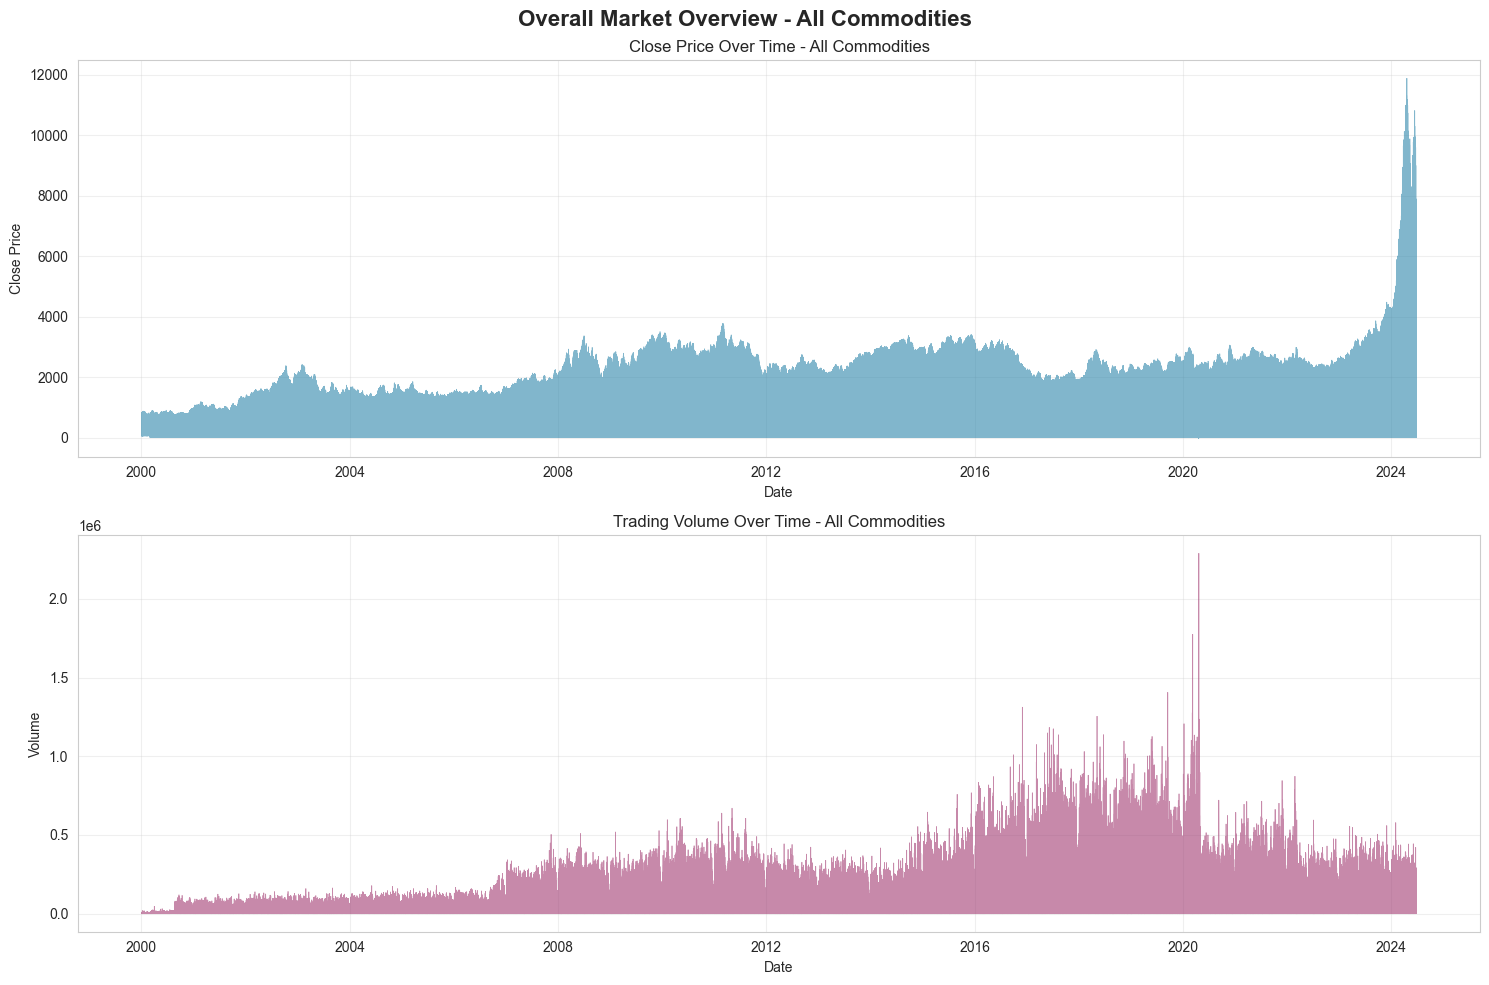

✓ Saved: close_price_by_commodity.png


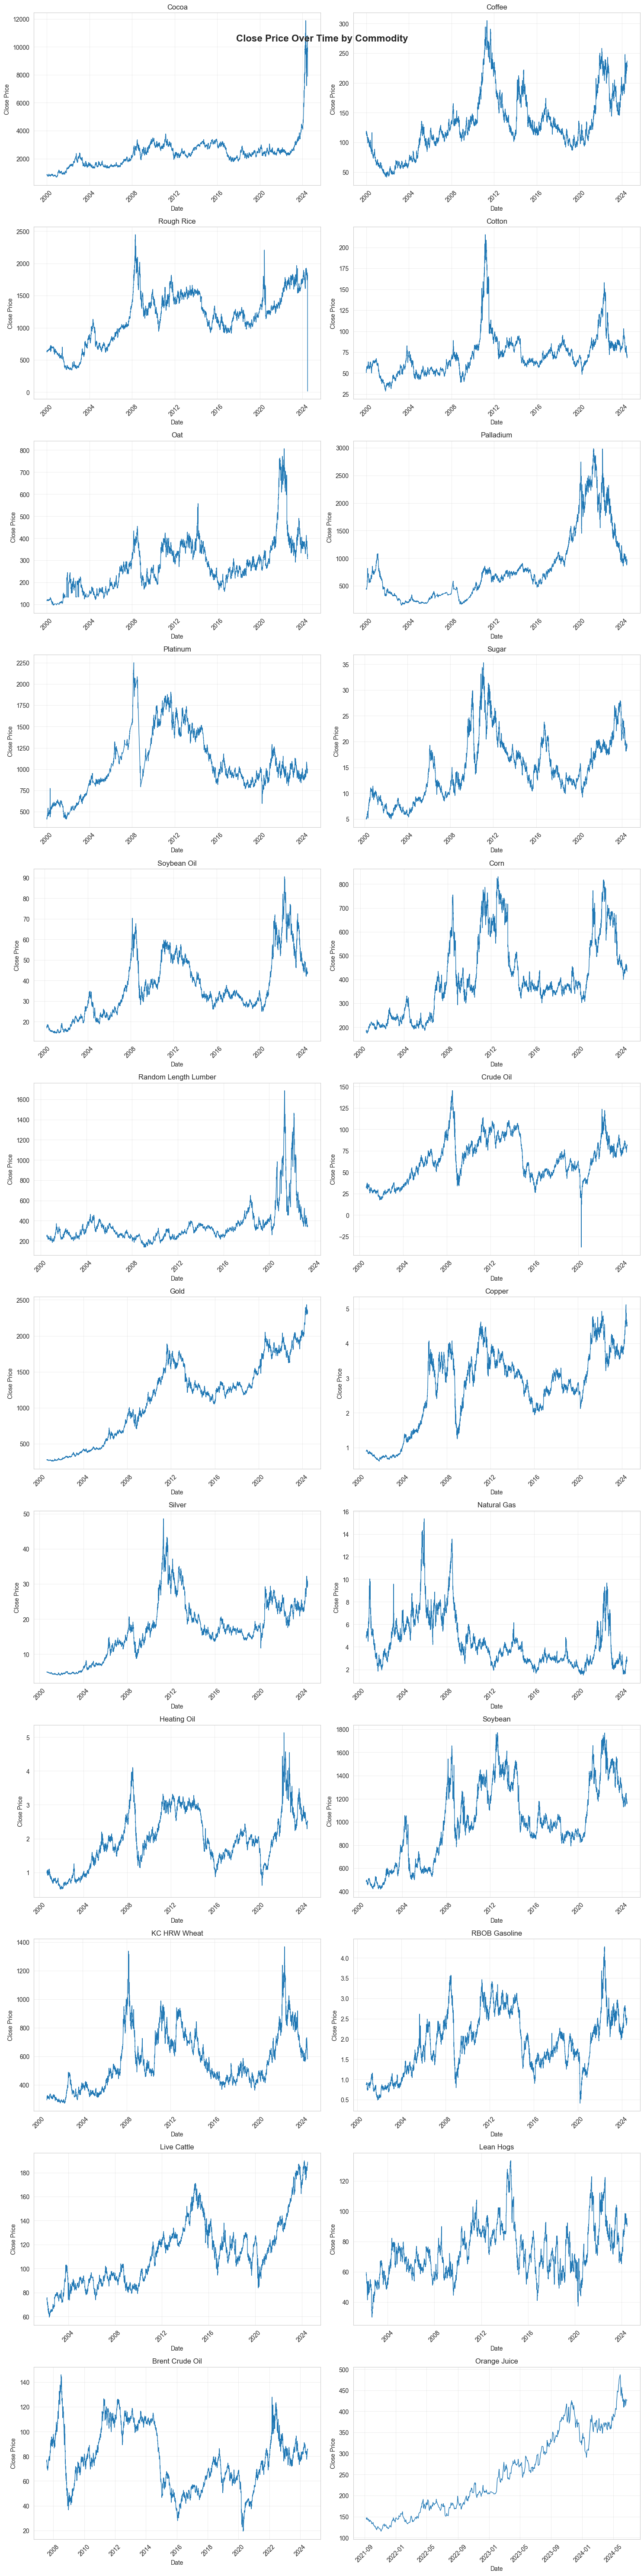

✓ Saved: daily_returns_by_commodity.png


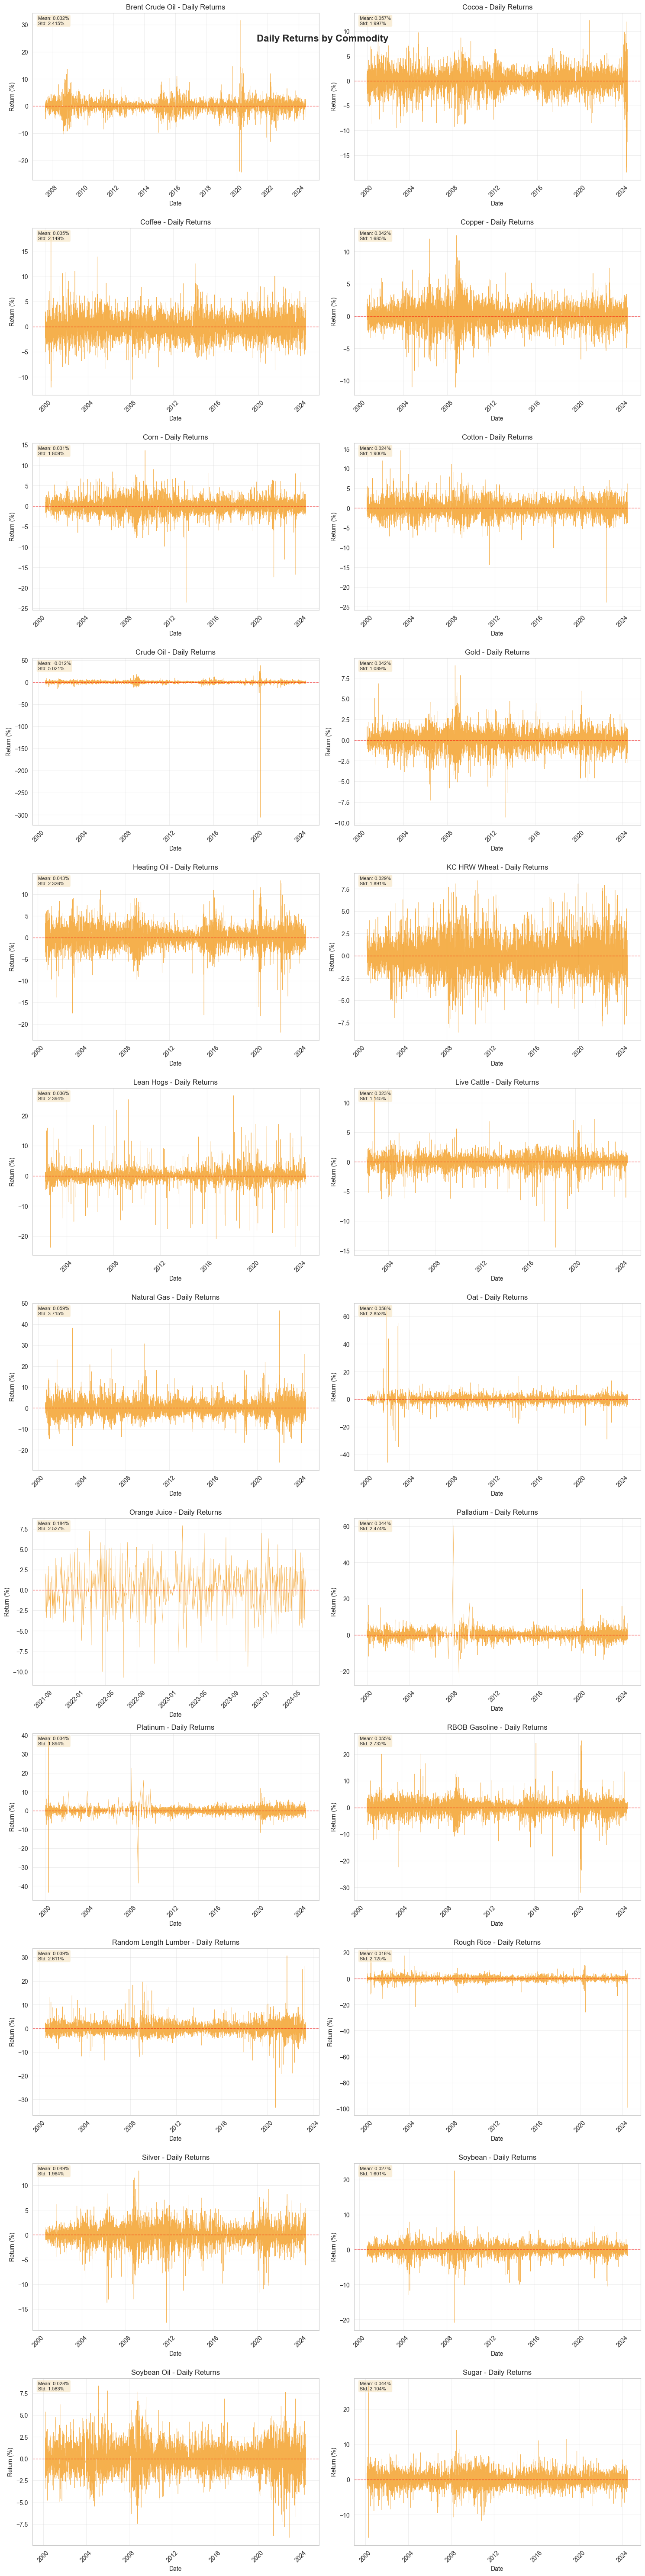

✓ Saved: commodity_correlation_matrix.png


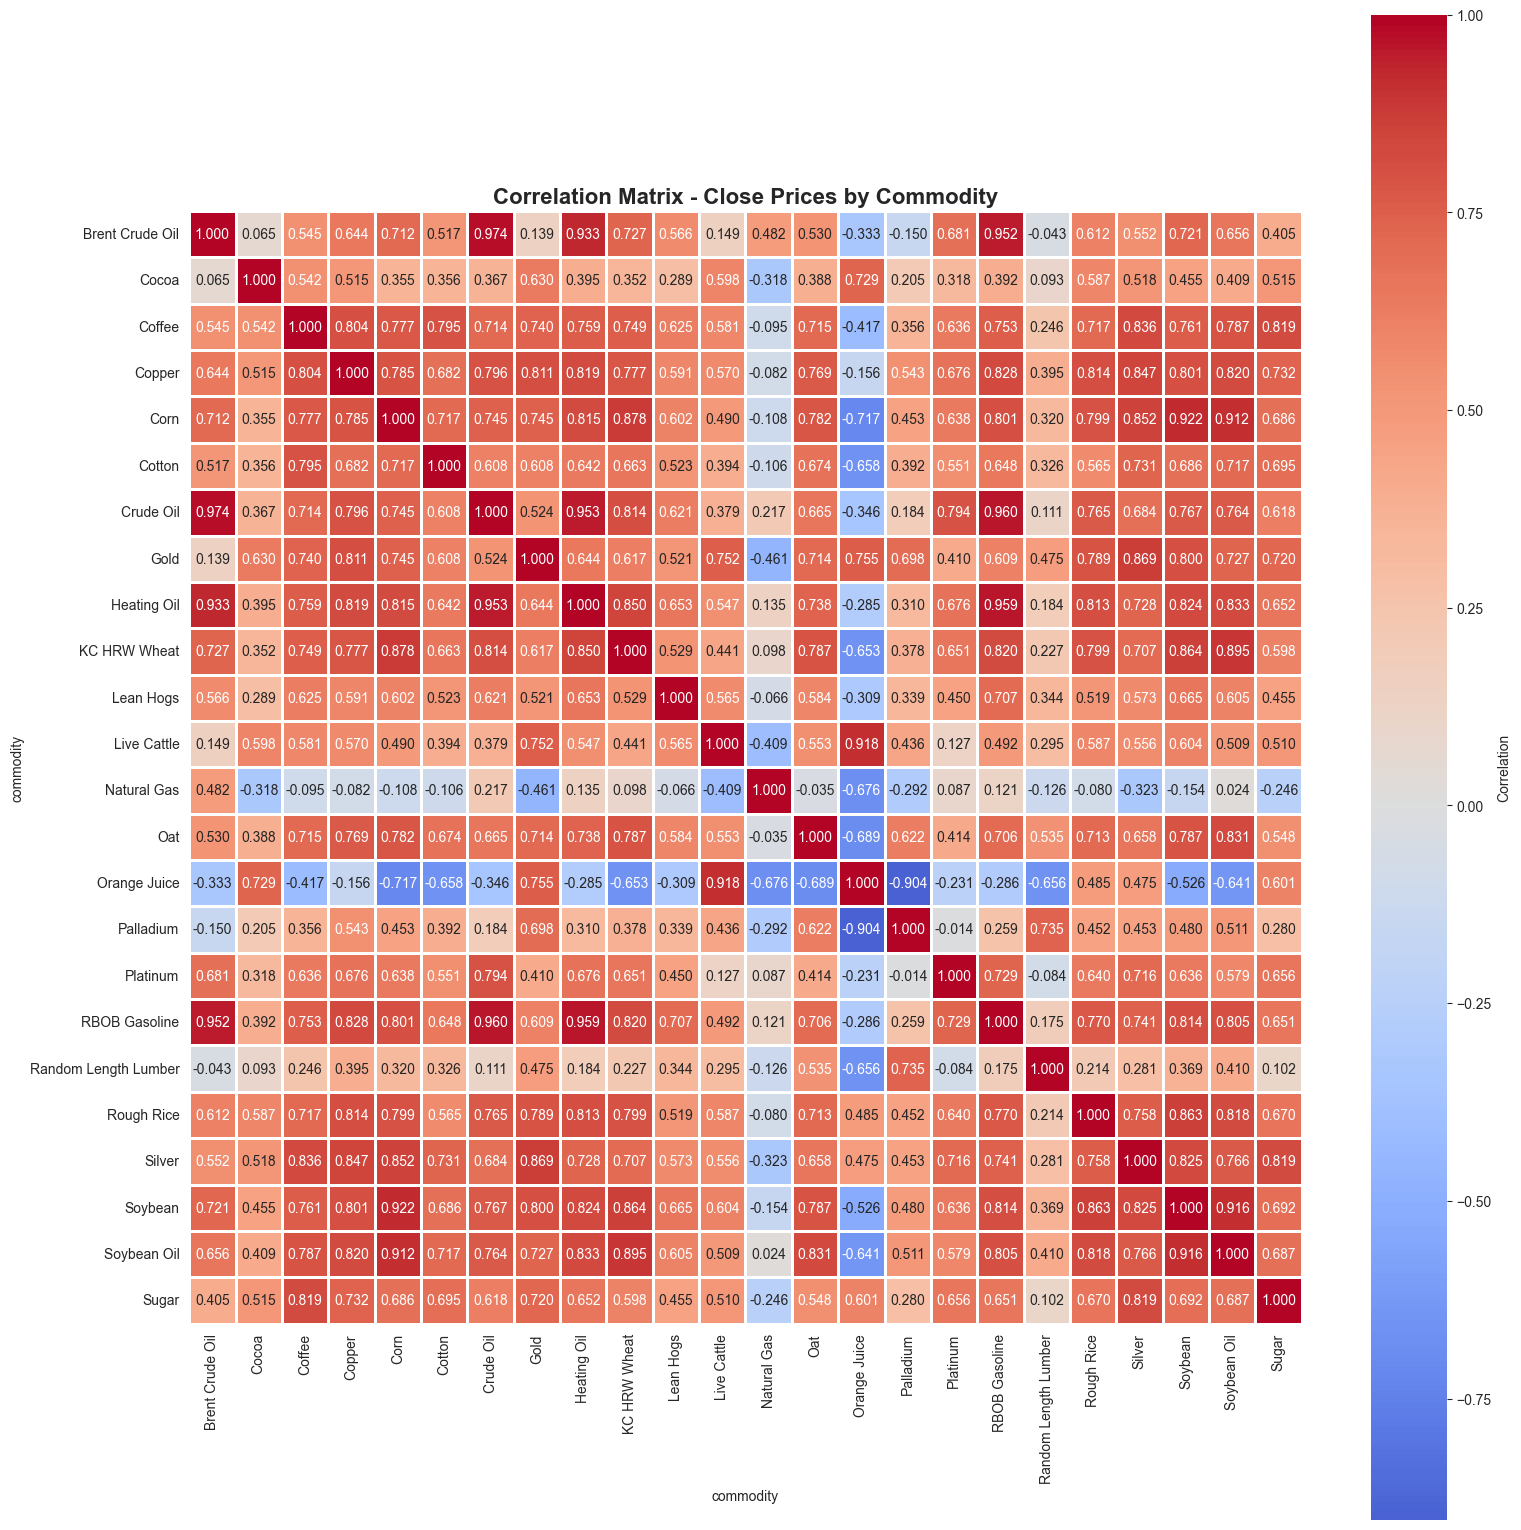



Correlation Matrix Values:
commodity             Brent Crude Oil  Cocoa  Coffee  Copper   Corn  Cotton  \
commodity                                                                     
Brent Crude Oil                 1.000  0.065   0.545   0.644  0.712   0.517   
Cocoa                           0.065  1.000   0.542   0.515  0.355   0.356   
Coffee                          0.545  0.542   1.000   0.804  0.777   0.795   
Copper                          0.644  0.515   0.804   1.000  0.785   0.682   
Corn                            0.712  0.355   0.777   0.785  1.000   0.717   
Cotton                          0.517  0.356   0.795   0.682  0.717   1.000   
Crude Oil                       0.974  0.367   0.714   0.796  0.745   0.608   
Gold                            0.139  0.630   0.740   0.811  0.745   0.608   
Heating Oil                     0.933  0.395   0.759   0.819  0.815   0.642   
KC HRW Wheat                    0.727  0.352   0.749   0.777  0.878   0.663   
Lean Hogs              

In [66]:
# Ensure date is datetime
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

# Sort by date for proper plotting
df = df.sort_values('date')

# 1. Overall Volume and Close Price
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Overall Market Overview - All Commodities', fontsize=16, fontweight='bold')

# Close price over time (all commodities)
axes[0].plot(df['date'], df['close'], linewidth=0.5, color='#2E86AB', alpha=0.6)
axes[0].set_title('Close Price Over Time - All Commodities')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Price')
axes[0].grid(True, alpha=0.3)

# Volume over time (all commodities)
axes[1].plot(df['date'], df['volume'], linewidth=0.5, color='#A23B72', alpha=0.6)
axes[1].set_title('Trading Volume Over Time - All Commodities')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volume')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('overall_market.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: overall_market.png")
plt.show()

# 2. Close Price by Commodity
if 'commodity' in df.columns:
    commodities = df['commodity'].unique()
    n_commodities = len(commodities)
    
    # Create subplots for each commodity
    n_cols = 2
    n_rows = (n_commodities + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Close Price Over Time by Commodity', fontsize=16, fontweight='bold')
    
    if n_commodities == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, commodity in enumerate(commodities):
        commodity_data = df[df['commodity'] == commodity].sort_values('date')
        axes[idx].plot(commodity_data['date'], commodity_data['close'], linewidth=1)
        axes[idx].set_title(f'{commodity}')
        axes[idx].set_xlabel('Date')
        axes[idx].set_ylabel('Close Price')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)
    
    # Hide extra subplots if any
    for idx in range(n_commodities, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('close_price_by_commodity.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: close_price_by_commodity.png")
    plt.show()

# 3. Daily Returns by Commodity
if 'commodity' in df.columns:
    # Calculate returns properly for each commodity separately
    df = df.sort_values(['commodity', 'date'])
    df['daily_return'] = df.groupby('commodity')['close'].pct_change() * 100
    
    commodities = df['commodity'].unique()
    n_commodities = len(commodities)
    
    n_cols = 2
    n_rows = (n_commodities + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Daily Returns by Commodity', fontsize=16, fontweight='bold')
    
    if n_commodities == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, commodity in enumerate(commodities):
        commodity_data = df[df['commodity'] == commodity].sort_values('date')
        axes[idx].plot(commodity_data['date'], commodity_data['daily_return'], 
                        linewidth=0.5, color='#F18F01', alpha=0.7)
        axes[idx].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
        axes[idx].set_title(f'{commodity} - Daily Returns')
        axes[idx].set_xlabel('Date')
        axes[idx].set_ylabel('Return (%)')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add statistics on plot
        mean_return = commodity_data['daily_return'].mean()
        std_return = commodity_data['daily_return'].std()
        axes[idx].text(0.02, 0.98, f'Mean: {mean_return:.3f}%\nStd: {std_return:.3f}%',
                        transform=axes[idx].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                        fontsize=8)
    
    # Hide extra subplots if any
    for idx in range(n_commodities, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('daily_returns_by_commodity.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: daily_returns_by_commodity.png")
    plt.show()

# 4. Correlation Matrix of Close Prices by Commodity
if 'commodity' in df.columns:
    # Pivot to get close prices for each commodity over time
    price_pivot = df.pivot_table(
        values='close', 
        index='date', 
        columns='commodity'
    )
    
    # Calculate correlation
    correlation_matrix = price_pivot.corr()
    
    plt.figure(figsize=(16, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=1, fmt='.3f', cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Matrix - Close Prices by Commodity', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('commodity_correlation_matrix.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: commodity_correlation_matrix.png")
    plt.show()
    
    print("\n\nCorrelation Matrix Values:")
    print(correlation_matrix.round(3))